# Neural Style Transfer

This is my implementation of [PyTorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) on neural style transfer.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image 
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = "cpu" #torch.device("cuda")

images need to be converted to be values between 0 and 1 and they need to be resided to have the same dimensions.

In [3]:
def image_loader(image_name):
    image_size = 128
    image = Image.open(image_name)
    # resize image
    image = transforms.Resize(image_size)(image)
    # convert to tensor
    image = transforms.ToTensor()(image)
    # create a minibatch of a single image
    image = image.unsqueeze(0)
    return image.to(device, torch.float)

In [6]:
style_image = image_loader("./data/images/style.jpg")
content_image = image_loader("./data/images/content.jpg")

In [7]:
# image sizes
print(f"Style Image: {style_image.size()}")
print(f"Content Image: {content_image.size()}")

Style Image: torch.Size([1, 3, 128, 128])
Content Image: torch.Size([1, 3, 128, 128])


In [8]:
def image_show(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

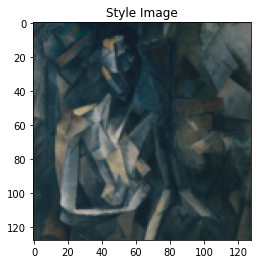

In [9]:
image_show(style_image, title="Style Image")

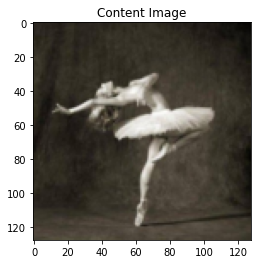

In [10]:
image_show(content_image, title="Content Image")

## Loss functions

In [11]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [12]:
def gram_matrix(input):
    batch_num, feature_num, width, height = input.size()
    
    features = input.view(batch_num*feature_num, width*height)
    # gram matrix is result of multipying a mtrix by its transpose
    G = torch.mm(features, features.t())
    # normalize gram matrix by dividing by total number of elements
    G = G.div(batch_num * feature_num * width * height)
    return G

class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Loading the Model

We will use a pretrained VGG model without the fully connected layer and use the output of the convolution layers to measure the content and style losses.

In [18]:
cnn = models.vgg19(pretrained=True)
cnn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

The model consists of two parts ```features``` containing the convolutions and the ```classifier``` part. We are only interested in the ```features``` part.

In [19]:
cnn = cnn.features.to(device).eval()

VGG was trained with images that were normalized using ```mean=[0.485, 0.456, 0.406]``` and ```std=[0.229, 0.224, 0.225]```. We need to do the same for our images before using the model.

In [20]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [21]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

Now we need to add our content and style loss after the ```freatures``` module of VGG.

In [22]:
content_layers = ['conv_4']
style_layers = ['conv_1, conv_2', 'conv_3', 'conv_4', 'conv_5']

content_losses = []
style_losses = []

cnn = copy.deepcopy(cnn)

# normalization layer
normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)

model = nn.Sequential(normalization)

# add content and style loss ater each conv layer
i = 0
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # replace to play nicely with content and style loss
        # see: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RunTimeError('unrecognized layer')
    
    model.add_module(name, layer)
    
    if name in content_layers:
        target = model(content_image).detach()
        content_loss = ContentLoss(target)
        model.add_module('content_loss_{}'.format(i), content_loss)
        content_losses.append(content_loss)
        
    if name in style_layers:
        target_feature = model(style_image).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module('style_loss_{}'.format(i), style_loss)
        style_losses.append(style_loss)
        
# trim off layers after the last content and style losses
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break
    
model = model[:(i + 1)] 

we can start with a white noise image as input and by the end of training it should be transformed into an image that contains the content of the ```content_image``` in the style of the ```style_image```

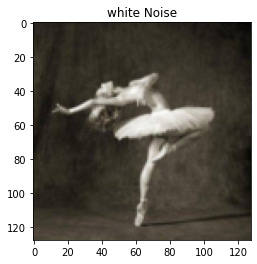

In [23]:
input_image = content_image.clone() #torch.randn(*content_image.shape).to(device)
image_show(input_image, title='white Noise')

## Training the Model

As per the paper, we will use L-BFGS algorithm to run gradient descent. Here the goal is to train the input image to minimize the style/content losses.

In [24]:
def style_transfer(model, 
                   input_image,
                   style_weight=1000000, 
                   content_weight=1,
                   num_steps=300):
    
    optimizer = optim.LBFGS([input_image.requires_grad_()])
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            
            input_image.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_image)
            style_score = 0
            content_score = 0
            
            for styl in style_losses:
                style_score += styl.loss
                
            for cnt in content_losses:
                content_score += cnt.loss
                
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            
            if run[0] % 50 == 0:
                print(f"run {run}")
                print(f"Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}")
                print()
              
            return style_score + content_score
        
        optimizer.step(closure)
        
    # limit value of image to be between 0 and 1
    input_image.data.clamp_(0, 1)
            
    return input_image

In [25]:
output = style_transfer(model, input_image)

run [50]
Style Loss : 78.236420 Content Loss: 18.292542

run [100]
Style Loss : 12.531338 Content Loss: 16.806946

run [150]
Style Loss : 6.024534 Content Loss: 14.696572

run [200]
Style Loss : 4.117082 Content Loss: 12.858567

run [250]
Style Loss : 3.234976 Content Loss: 11.350531

run [300]
Style Loss : 2.677404 Content Loss: 10.258799



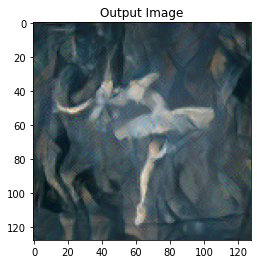

In [103]:
image_show(output, title='Output Image')